In [1]:
'''
Enviroment: Ubuntu 16.04 + TensorFlow 1.12.0 + cuda 9.0 + python 3.6
Dataset: Cityscapes, https://www.kaggle.com/dansbecker/cityscapes-image-pairs
Segmentation Model: UNet 
Adversarial Model: ??
Metric: Mean Intersection over Union(MIoU)=TP/(TP+FN+FP)
'''
import numpy as np
import argparse
import json
from os.path import join
import tensorflow as tf
import glob
from PIL import Image , ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.eager as tfe
import sys
print(tf.VERSION) 
print(sys.version)

1.12.0
3.6.6 (default, Jun 28 2018, 04:42:43) 
[GCC 5.4.0 20160609]


In [2]:
#binarize the value of label to 0 or 1
def binarize( pixel ):
    if np.array_equal( pixel , [ 128, 63,127 ]):#road 
        return np.array( [ 1 ] )
    elif np.array_equal( pixel , [ 70, 70, 70 ]):#building
        return np.array( [ 2 ] )
    elif np.array_equal( pixel , [ 220, 20, 60 ]):#person
        return np.array( [ 3 ] )
    elif np.array_equal( pixel , [ 0,  0, 142 ]):#car
        return np.array( [ 4 ] )
    elif np.array_equal( pixel , [ 70,130,180 ]):#sky
        return np.array( [ 5 ] )
    else :
        return np.array( [ 0 ] )
#train set
def trainDataset(train_dir):
    X_train = list()
    Y_train = list()
    for filename in os.listdir( train_dir ): 
        image = Image.open(os.path.join( train_dir, filename))
        X_train.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) ) #real image
        Y_train.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) )) #labelled image
    return np.array(X_train)/255, np.array(Y_train)
train_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/train'
X_train, Y_train = trainDataset(train_dir)
Y_train = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_train) ) #classify the pixel
print ('The size of feature in Train set is : {}'.format(X_train.shape))
print ('The size of label in Train set is : {}'.format(Y_train.shape))

#val set
def valDataset(val_dir):
    X_val = list()
    Y_val = list()
    for filename in os.listdir( val_dir ): 
        image = Image.open(os.path.join( val_dir, filename))
        X_val.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
        Y_val.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))
    return np.array(X_val)/255, np.array(Y_val)
val_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/val'
X_val,Y_val = valDataset(val_dir)
Y_val = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_val) ) #classify the pixel
print ('The size of feature in Val set is: {}'.format(X_val.shape))
print ('The size of label in Val set is : {}'.format(Y_val.shape))

The size of feature in Train set is : (2975, 128, 128, 3)
The size of label in Train set is : (2975, 128, 128, 1)
The size of feature in Val set is: (500, 128, 128, 3)
The size of label in Val set is : (500, 128, 128, 1)


In [3]:
class unet_seg:
    def __init__(self, lr=0.001):
        #global parameters
        self.lr = lr
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder(tf.float32)
        self.Y_input = tf.placeholder(tf.float32)
    
    def add_weight(self):
        initializer = tf.initializers.glorot_uniform()
        def get_weight( shape , name ):
            return tf.Variable( initializer( shape ) , name=name , trainable=True )

        shapes = [ [ 3 , 3 , 3 , 16 ] ,   [ 3 , 3 , 16 , 16 ] , 
                   [ 3 , 3 , 16 , 32 ] ,  [ 3 , 3 , 32 , 32 ] ,
                   [ 3 , 3 , 32 , 64 ] ,  [ 3 , 3 , 64 , 64 ] ,
                   [ 3 , 3 , 64 , 128 ] , [ 3 , 3 , 128 , 128 ] ,
                   [ 3 , 3 , 128 , 256 ] ,[ 3 , 3 , 256 , 256 ] ,
                   [ 3 , 3 , 128 , 384 ], [ 3 , 3 , 128 , 128 ],
                   [ 3 , 3 , 64 , 192 ],  [ 3 , 3 , 64 , 64 ],
                   [ 3 , 3 , 32 , 96 ],   [ 3 , 3 , 32 , 32 ],
                   [ 3 , 3 , 16 , 48 ],   [ 3 , 3 , 16 , 16 ],
                   [ 1 , 1 , 16 , 1 ] #one dimension of outputs
                 ]
        weights = []
        for i in range( len( shapes ) ):
            weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )
        self.weights = weights
        
    def add_model(self):
        def conv2d_down( inputs , filters , stride_size ):
            #print( 'conv2d down' )
            #[filter_height, filter_width, in_channels, out_channels]
            out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_down( inputs , pool_size , stride_size ):
            #print( 'maxpool down' )
            return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

        def conv2d_up( inputs , filters , stride_size , output_shape ):
            #print( 'conv2d up' )
            out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_up( inputs , size ):
            #print( 'maxpool up' )
            in_dimen = tf.shape( inputs )[ 1 ]
            out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
            return tf.image.resize_images( inputs , [ out_dimen , out_dimen ] , method=1 )#nearest
        #forward
        x = tf.cast(self.X_input , dtype=tf.float32 )
        batch_size = tf.shape( x )[0]
        c1 = conv2d_down( x , self.weights[ 0 ] , stride_size=[1,1,1,1] ) 
        c1 = conv2d_down( c1 , self.weights[ 1 ] , stride_size=[1,1,1,1] ) 
        p1 = maxpool_down( c1 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c2 = conv2d_down( p1 , self.weights[ 2 ] , stride_size=[1,1,1,1] )
        c2 = conv2d_down( c2 , self.weights[ 3 ] , stride_size=[1,1,1,1] ) 
        p2 = maxpool_down( c2 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c3 = conv2d_down( p2 , self.weights[ 4 ] , stride_size=[1,1,1,1] ) 
        c3 = conv2d_down( c3 , self.weights[ 5 ] , stride_size=[1,1,1,1] ) 
        p3 = maxpool_down( c3 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c4 = conv2d_down( p3 , self.weights[ 6 ] , stride_size=[1,1,1,1] )
        c4 = conv2d_down( c4 , self.weights[ 7 ] , stride_size=[1,1,1,1] )
        p4 = maxpool_down( c4 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c5 = conv2d_down( p4 , self.weights[ 8 ] , stride_size=[1,1,1,1] )
        c5 = conv2d_down( c5 , self.weights[ 9 ] , stride_size=[1,1,1,1] )   

        p5 = maxpool_up( c5 , 2 )
        concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
        c6 = conv2d_up( concat_1 , self.weights[ 10 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )
        c6 = conv2d_up( c6 , self.weights[ 11 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )  

        p6 = maxpool_up( c6 , 2 )
        concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
        c7 = conv2d_up( concat_2 , self.weights[ 12 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )
        c7 = conv2d_up( c7 , self.weights[ 13 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )  

        p7 = maxpool_up( c7 , 2 )
        concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
        c8 = conv2d_up( concat_3 , self.weights[ 14 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )
        c8 = conv2d_up( c8 , self.weights[ 15 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )   

        p8 = maxpool_up( c8 , 2 )
        concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
        c9 = conv2d_up( concat_4 , self.weights[ 16 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )
        c9 = conv2d_up( c9 , self.weights[ 17 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )  

        output = tf.nn.conv2d( c9 , self.weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding='SAME' ) 
        self.Y_output = output
    
    def add_loss(self):
        #self.loss = tf.losses.sigmoid_cross_entropy( self.Y_input , self.Y_output ) 
        self.loss = tf.losses.mean_squared_error( self.Y_input , self.Y_output)
    
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
#define model
tf_model = unet_seg()

In [7]:
#verbose = 10
batchSize=256
num_batches = X_train.shape[0] // batchSize + 1 
pre_loss = 0.0
while True:#convergence
    losses = []
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([X_train.shape[0], (i+1)*batchSize])
        X_batch = X_train[min_idx: max_idx]
        Y_batch = Y_train[min_idx: max_idx]
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                         feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch})
        losses.append(tmp_loss)
        #if verbose and i % verbose == 0:
        #    sys.stdout.write('\r{} / {} : loss = {}'.format(i, num_batches, np.mean(losses[-verbose:])))
        #    sys.stdout.flush()
    sys.stdout.write("Mean loss in this epoch is: {}\n".format( np.mean(losses) ))
    sys.stdout.flush()
    #whether convergence
    if abs( np.mean(losses) - pre_loss)<0.001:
        break
    else:
        pre_loss = np.mean(losses)

Mean loss in this epoch is: 0.7209380269050598
Mean loss in this epoch is: 0.7007498145103455
Mean loss in this epoch is: 0.7113800048828125
Mean loss in this epoch is: 0.6882066130638123
Mean loss in this epoch is: 0.685899555683136
Mean loss in this epoch is: 0.6719856262207031
Mean loss in this epoch is: 0.6594262719154358
Mean loss in this epoch is: 0.6756952404975891
Mean loss in this epoch is: 0.6488024592399597
Mean loss in this epoch is: 0.6563886404037476
Mean loss in this epoch is: 0.6395191550254822
Mean loss in this epoch is: 0.6293654441833496
Mean loss in this epoch is: 0.61970454454422
Mean loss in this epoch is: 0.6124429702758789
Mean loss in this epoch is: 0.5784285068511963
Mean loss in this epoch is: 0.577411949634552
Mean loss in this epoch is: 0.5876155495643616
Mean loss in this epoch is: 0.5589424967765808
Mean loss in this epoch is: 0.5475074648857117
Mean loss in this epoch is: 0.5411521792411804
Mean loss in this epoch is: 0.520947277545929
Mean loss in this 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


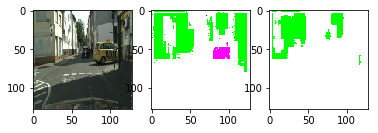

In [8]:
#for classification
def sigmoid(x):
    s = 1/(1+np.exp(-x)) 
    return s

Y_label = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):#http://www.wahart.com.hk/rgb.htm
        if Y_val[0, x , y ]== 1:#road
            Y_label[ x , y ] = [ 193, 205, 205] #Azure3
        elif Y_val[0, x , y ]== 2:#buliding
            Y_label[ x , y ] = [ 0, 100, 0] #DarkGreen
        elif Y_val[0, x , y ]== 3:#person
            Y_label[ x , y ] = [ 205, 92, 92] #IndianRed
        elif Y_val[0, x , y ]== 4:#car
            Y_label[ x , y ] = [ 255, 0, 255] #Magenta
        elif Y_val[0, x , y ]== 5:#sky
            Y_label[ x , y ] = [ 0, 0, 255] #Blue1
        else:
            Y_label[ x , y ] = [ 255, 255, 255] #white
            
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val[0:1],tf_model.Y_input: Y_val[0:1]})
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if 0.5 < Y_pred[0, x , y ] <= 1.5: #road
            image[ x , y ] = [ 193, 205, 205] #Azure3
        elif 1.5< Y_pred[0, x , y ] <= 2.5: #buliding
            image[ x , y ] = [ 0, 100, 0] #DarkGreen
        elif 2.5< Y_pred[0, x , y ] <= 3.5:#person
            image[ x , y ] = [ 205, 92, 92] #IndianRed
        elif 3.5< Y_pred[0, x , y ] <= 4.5:#car
            image[ x , y ] = [ 255, 0, 255] #Magenta
        elif 4.5< Y_pred[0, x , y ] <= 5.5:#sky
            image[ x , y ] = [ 0, 0, 255] #Blue1
        else:#<0.5 and >5.5 
            image[ x , y ] = [ 255, 255, 255] #white
            
def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()
    
show_images( [ X_val[0], Y_label, image ] )

In [9]:
#performance Structural segmentation (six categories)
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val}) #prediction
mIoUs = []
intersection = []
union = []
for i in range(len(Y_val)):
    a = Y_pred[i]
    b = Y_val[i]
    iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    mIoUs.append(np.mean(iou_score))
    sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), np.mean(iou_score)))
    sys.stdout.flush()
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

#turn the value of prediciton to label
def ValueToLabel(x):
    if 0.5 < x <= 1.5: #road
        return 1
    elif 1.5< x <= 2.5: #buliding
        return 2
    elif 2.5< x <= 3.5:#person
        return 3
    elif 3.5< x <= 4.5:#car
        return 4
    elif 4.5< x <= 5.5:#sky
        return 5
    else:#<0.5 and >5.5 
        return 0
Y_pred = np.apply_along_axis(ValueToLabel, -1, Y_pred).reshape(500,128,128,1)#turn value to label
for i in range(5):#5 types
    mIoUs = []
    for j in range(len(Y_val)):
        a = Y_pred[j]
        b = Y_val[j]
        #a_t = np.where( ((i+1.5)<a.flatten()) & (a.flatten()<=(i+2.5)),1,0)
        a_t = np.where(a.flatten()==(i+1),1,0)
        b_t = np.where(b.flatten()==(i+1),1,0)
        intersection=np.logical_and(a_t,b_t)
        union=np.logical_or(a_t,b_t)
        iou_t = np.sum(intersection) / np.sum(union)
        mIoUs.append(iou_t)
    print('Label:{}===> mIoU:{}'.format(str(i+1), str(round(np.nanmean(mIoUs) * 100, 2))))

499 / 500 : IoU = 0.94903564453125===> mIoU: 82.13
Label:1===> mIoU:62.41
Label:2===> mIoU:10.46
Label:3===> mIoU:0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


Label:4===> mIoU:9.98
Label:5===> mIoU:5.82


In [10]:
#generate adversial samples
#https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
def create_adversarial_pattern(input_image, input_label):
    _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                    feed_dict={tf_model.X_input: input_image,tf_model.Y_input: input_label})
    # Get the gradients of the loss w.r.t to the input image.
    gradients_node = tf.gradients(tmp_loss, X_input)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradients_node)
    return tf_model.sess.run(signed_grad)

epsilons = [0, 0.01, 0.1, 0.15]
for i, eps in enumerate(epsilons):
    #perturbations = create_adversarial_pattern(X_val,Y_val)#calcuate gradient
    #adv_x = X_val + eps*perturbations
    adv_x = X_val + eps
    adv_x = tf.clip_by_value(adv_x, 0, 1)#adversarial samples
    adv_x= tf_model.sess.run(adv_x)
    Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: adv_x,tf_model.Y_input: Y_val}) #prediction
    mIoUs = []
    intersection = []
    union = []
    for i in range(len(Y_val)):
        a = Y_pred[i]
        b = Y_val[i]
        iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
        mIoUs.append(np.mean(iou_score))
        sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), np.mean(iou_score)))
        sys.stdout.flush()
    print('Perturb:{}===> mIoU{}'.format(eps,str(round(np.nanmean(mIoUs) * 100, 2))))

499 / 500 : IoU = 0.94903564453125Perturb:0===> mIoU82.13
499 / 500 : IoU = 0.95104980468755Perturb:0.01===> mIoU81.89
499 / 500 : IoU = 0.90234375234375Perturb:0.1===> mIoU77.37
499 / 500 : IoU = 0.86303710937555Perturb:0.15===> mIoU72.69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


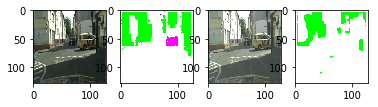

In [11]:
Y_label = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):#http://www.wahart.com.hk/rgb.htm
        if Y_val[0, x , y ]== 1:#road
            Y_label[ x , y ] = [ 193, 205, 205] #Azure3
        elif Y_val[0, x , y ]== 2:#buliding
            Y_label[ x , y ] = [ 0, 100, 0] #DarkGreen
        elif Y_val[0, x , y ]== 3:#person
            Y_label[ x , y ] = [ 205, 92, 92] #IndianRed
        elif Y_val[0, x , y ]== 4:#car
            Y_label[ x , y ] = [ 255, 0, 255] #Magenta
        elif Y_val[0, x , y ]== 5:#sky
            Y_label[ x , y ] = [ 0, 0, 255] #Blue1
        else:
            Y_label[ x , y ] = [ 255, 255, 255] #white
            
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: adv_x[0:1],tf_model.Y_input: Y_val[0:1]})
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if 0.5 < Y_pred[0, x , y ] <= 1.5: #road
            image[ x , y ] = [ 193, 205, 205] #Azure3
        elif 1.5< Y_pred[0, x , y ] <= 2.5: #buliding
            image[ x , y ] = [ 0, 100, 0] #DarkGreen
        elif 2.5< Y_pred[0, x , y ] <= 3.5:#person
            image[ x , y ] = [ 205, 92, 92] #IndianRed
        elif 3.5< Y_pred[0, x , y ] <= 4.5:#car
            image[ x , y ] = [ 255, 0, 255] #Magenta
        elif 4.5< Y_pred[0, x , y ] <= 5.5:#sky
            image[ x , y ] = [ 0, 0, 255] #Blue1
        else:#<0.5 and >5.5 
            image[ x , y ] = [ 255, 255, 255] #white
            
def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()
    
show_images( [ X_val[0], Y_label, adv_x[0], image ] )

In [83]:
import numpy as np
import tensorflow as tf
 
sess = tf.Session()
 
x_input = tf.placeholder(tf.float32, name='x_input')
y_input = tf.placeholder(tf.float32, name='y_input')
w = tf.Variable(2.0, name='weight')
b = tf.Variable(1.0, name='biases')
y = tf.add(tf.multiply(x_input, w), b)
loss_op = tf.reduce_sum(tf.pow(y_input - y, 2)) / (2 * 32)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss_op)
 
'''tensorboard'''
gradients_node = tf.gradients(loss_op, w)
# print(gradients_node)
# tf.summary.scalar('norm_grads', gradients_node)
# tf.summary.histogram('norm_grads', gradients_node)
# merged = tf.summary.merge_all()
# writer = tf.summary.FileWriter('log')
 
init = tf.global_variables_initializer()
sess.run(init)
 
'''构造数据集'''
x_pure = np.random.randint(-10, 100, 32)
x_train = x_pure + np.random.randn(32) / 10  # 为x加噪声
y_train = 3 * x_pure + 2 + np.random.randn(32) / 10  # 为y加噪声
 
for i in range(20):
    _, gradients, loss = sess.run([train_op, gradients_node, loss_op],
                                  feed_dict={x_input: x_train[i], y_input: y_train[i]})
    print("epoch: {} \t loss: {} \t gradients: {}".format(i, loss, gradients))
sess.close()

epoch: 0 	 loss: 156.16941833496094 	 gradients: [-309.14725]
epoch: 1 	 loss: 3.3412024974823 	 gradients: [2.823508]
epoch: 2 	 loss: 24.550569534301758 	 gradients: [24.613335]
epoch: 3 	 loss: 272.4517822265625 	 gradients: [301.59607]
epoch: 4 	 loss: 48.34321594238281 	 gradients: [-80.343124]
epoch: 5 	 loss: 7.224512100219727 	 gradients: [-35.69277]
epoch: 6 	 loss: 0.13303275406360626 	 gradients: [-4.3764615]
epoch: 7 	 loss: 0.006268377881497145 	 gradients: [-0.7925899]
epoch: 8 	 loss: 0.0006628251867368817 	 gradients: [0.521434]
epoch: 9 	 loss: 0.0048302458599209785 	 gradients: [-1.215866]
epoch: 10 	 loss: 8.416864147875458e-05 	 gradients: [-0.087242074]
epoch: 11 	 loss: 0.0003730601747520268 	 gradients: [-0.19315936]
epoch: 12 	 loss: 0.009349174797534943 	 gradients: [2.1014004]
epoch: 13 	 loss: 0.005559502635151148 	 gradients: [-0.8969071]
epoch: 14 	 loss: 8.094534859992564e-05 	 gradients: [-0.12165163]
epoch: 15 	 loss: 0.01436783280223608 	 gradients: [0.

In [29]:
#https://github.com/wasidennis/AdaptSegNet/blob/master/compute_iou.py
#https://blog.csdn.net/jiongnima/article/details/84750819
info = {"classes":19,
  "label2train":[[0, 255],[1, 255], [2, 255],[3, 255],[4, 255],[5, 255],[6, 255],[7, 0],[8, 1],[9, 255],[10, 255],
                 [11, 2],[12, 3],[13, 4],[14, 255],[15, 255],[16, 255],[17, 5],[18, 255],[19, 6],[20, 7],
                 [21, 8],[22, 9],[23, 10],[24, 11],[25, 12],[26, 13],[27, 14],[28, 15],[29, 255],[30, 255],
                 [31, 16],[32, 17],[33, 18],[-1, 255]],
  "label":[ "road","sidewalk","building","wall","fence","pole","light","sign","vegetation","terrain",
            "sky","person","rider","car","truck","bus","train","motocycle","bicycle"],
  "palette":[ [128,64,128],[244,35,232],[70,70,70],[102,102,156],[190,153,153],[153,153,153],[250,170,30],[220,220,0],
              [107,142,35],[152,251,152],[70,130,180],[220,20,60],[255,0,0],[0,0,142],[0,0,70],[0,60,100],[0,80,100],
              [0,0,230],[119,11,32],[0,0,0]],
  "mean":[73.158359210711552,82.908917542625858,72.392398761941593],
  "std":[ 47.675755341814678,48.494214368814916,47.736546325441594]
}

#evaluation
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    t = (n * a[k] + b[k]).astype(int)
    return np.bincount(t, minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


def label_mapping(label, mapping):
    output = np.copy(label)
    for ind in range(len(mapping)):
        output[label == mapping[ind][0]] = mapping[ind][1]
    return np.array(output, dtype=np.int64)

#turn the value of prediciton to label
def ValueToLabel(x):
    if 0.5 < x <= 1.5: #road
        return 1
    elif 1.5< x <= 2.5: #buliding
        return 2
    elif 2.5< x <= 3.5:#person
        return 3
    elif 3.5< x <= 4.5:#car
        return 4
    elif 4.5< x <= 5.5:#sky
        return 5
    else:#<0.5 and >5.5 
        return 0

#trun label to class of cityspcape according info.json
def LabelToClass(x):
    if x ==1: #road
        return 0
    elif x==2:#building
        return 2
    elif x==3:#person
        return 11
    elif x==4:#car 
        return 13
    elif x==5:#sky
        return 10
    else:
        return -1

#Compute IoU given the predicted colorized images
num_classes = np.int(info['classes'])
print('Num classes', num_classes)
name_classes = np.array(info['label'], dtype=np.str)
mapping = np.array(info['label2train'], dtype=np.int)
hist = np.zeros((num_classes, num_classes))
mIoUs = []
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val})
tmp_pred = np.apply_along_axis(ValueToLabel, -1, Y_pred).reshape(500,128,128,1) #turn value to label
image_pred = np.apply_along_axis(LabelToClass, -1, tmp_pred).reshape(500,128,128,1) #turn label to class
image_label = np.apply_along_axis(LabelToClass, -1, Y_val).reshape(500,128,128,1) #turn label to class
#iteration
for ind in range(len(image_label)):
    pred = image_pred[ind]
    label = image_label[ind]
    label = label_mapping(label, mapping)
    if len(label.flatten()) != len(pred.flatten()):
        print('Skipping: len(gt) = {:d}, len(pred) = {:d}, {:s}, {:s}'.format(len(label.flatten()), len(pred.flatten()), label[ind], pred[ind]))
        continue
    hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
    #if ind > 0 and ind % 100 == 0:
        #print('{:d} / {:d}: {:0.2f}'.format(ind, len(image_label), 100*np.mean(per_class_iu(hist))))
    
mIoUs = per_class_iu(hist)
for ind_class in range(num_classes):
    print('===>' + name_classes[ind_class] + ':\t' + str(round(mIoUs[ind_class] * 100, 2)))
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

Num classes 19
===>road:	0.0
===>sidewalk:	nan
===>building:	0.0
===>wall:	0.0
===>fence:	0.0
===>pole:	nan
===>light:	nan
===>sign:	nan
===>vegetation:	nan
===>terrain:	nan
===>sky:	0.0
===>person:	0.0
===>rider:	nan
===>car:	0.0
===>truck:	nan
===>bus:	nan
===>train:	nan
===>motocycle:	nan
===>bicycle:	0.0
===> mIoU: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [34]:
#check dataset, 
def value_count(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result

print (value_count(image_pred))
print (value_count(image_label))

{-1: 6534447, 0: 1337995, 2: 210951, 10: 10080, 11: 69811, 13: 28716}
{-1: 7314101, 2: 704942, 10: 41930, 13: 131027}
